In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statistics
import math
import pandas as pd
from scipy.stats import norm, lognorm

#from scipy.optimize import curve_fit
from matplotlib import cm,rc
#from scipy import interpolate
#from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline, PchipInterpolator, Akima1DInterpolator
#import gc

In [2]:
import os
os.chdir(os.getcwd())

In [3]:
def get_raw_data(path):
    with open(path,'rb') as f:
        raw_data = np.load(f)
    return raw_data

def get_thickness_values(K):
    '''function to get the known thickness values for the experiments'''
    exp_path = f'examples/fitted_experiments_whole_original_100_{K}K.npy'
    tar_path = f'examples/tar_{K}K.csv'
    exp_tar = pd.read_csv(tar_path) # read evaluation

    with open(exp_path,'rb') as f:
        a = np.load(f)
        exp_frames = np.load(f)
    exp_frames = np.transpose(exp_frames)[0] 
    exp_tar_filter = exp_tar[exp_tar.Frame.isin(exp_frames)]
    thickness_values = exp_tar_filter['thickness']
    thickness_values = np.array(thickness_values, dtype=np.float32)
    return thickness_values

def get_experiment_data(K):
    with open(f'examples/fitted_experiments_whole_original_100_{K}K.npy','rb') as f:
        exp_images = np.load(f)
        exp_tar = np.load(f)
    exp_df = pd.DataFrame(exp_tar,columns=['frame','distance','radius'])
    return exp_df.distance,exp_df.radius
        
def plot_bars(frames=range(0,310,60),save=False,label=False,flag='radius',k='100'):
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 7}
    rc('font', **font)
    
    means = np.arange(1.2,28.2,0.1) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance
    headers = get_thickness_values(k)
    for n_frame in frames:
        plt.figure(figsize=(4,3),dpi=200)
        
        # calculating weigted average, i.e expected radius
        expected_v = 0
        for i,m in enumerate(means):
            expected_v += (raw_data[n_frame][i]*m)
            
        # printing some labels
        for i,w in enumerate(raw_data[n_frame]): 
            index_is_gt_radius = (round(means[i],1) == round(radius[n_frame],1)) if flag=='radius' else (round(means[i],1) == round(distance[n_frame],1))
            index_is_expected_radius = round(means[i],1) == round(expected_v,1) and round(expected_v,1) != round(means[np.argmax(raw_data[n_frame])],1)
            if index_is_gt_radius:
                plt.annotate(f'GT= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+2.5,0.02),arrowprops=dict(facecolor='black', arrowstyle="->")) 
            if index_is_expected_radius:
                plt.annotate(f'Prediction= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+5.25,0.027),arrowprops=dict(facecolor='black', arrowstyle="->")) 
                
        # ploting bars 
        plt.bar(means, raw_data[n_frame], width=0.15, label='ANN')#,lw=0.5) 

        GT = round(radius[n_frame],1) # ground truth value

        
        # calculating the lognorm distribution with sigma = 1.2 from the paper: https://pubs.aip.org/aip/apl/article/104/24/243107/384820/Silver-substrates-for-surface-enhanced-Raman
        lognorm_curve = lognorm.pdf(means, 1.2/radius[n_frame], scale=radius[n_frame])
        log_curve_normalized = (lognorm_curve/np.sum(lognorm_curve))
        
        # calculating the weighted standard deviation
        stddev = np.sqrt(np.sum(raw_data[n_frame] * (means - expected_v)**2) / np.sum(raw_data[n_frame]))
        
        # calculating the lognorm distribution with the calculated std from above
        log_curve_pred_std = lognorm.pdf(means, s=stddev/expected_v, scale=expected_v)
        log_curve_normalized_pred_std = (log_curve_pred_std/np.sum(log_curve_pred_std))
        
        plt.plot(means, lognorm_curve, 'k-', lw=1, label='Theory',alpha=0.6)  # plot of the calculated lognormal curve with sigma=1.2
        plt.plot(means, log_curve_normalized, 'r-', lw=1, label='Theory - normalized curve')  # plot of the calculated normalized lognormal curve with sigma=1.2


        plt.plot(means, log_curve_pred_std, 'g-', lw=1, label=r'ANN $\sigma$=%.1f' % stddev)  # plot of the predicted lognormal curve 
        plt.plot(means, log_curve_normalized_pred_std, 'c-', lw=1, label=r'ANN - normalized $\sigma$=%.1f' % stddev) # plot of the predicted and normalized lognormal curve 


        title = r'Weights distribution and log-normal approx. with $\sigma/R = 1.2/GT$' + '\n'+ r'$\delta$ = %.1f nm' % headers[n_frame]
        plt.title(title)
        xlim = (0,28.2) if flag == 'radius'else (3.8,40.8)
        plt.ylim((0,0.06))
        plt.xlim(xlim)
        plt.ylabel('Probability')
        plt.xlabel('Radius (nm)')
        plt.legend()
        plt.show()
    

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


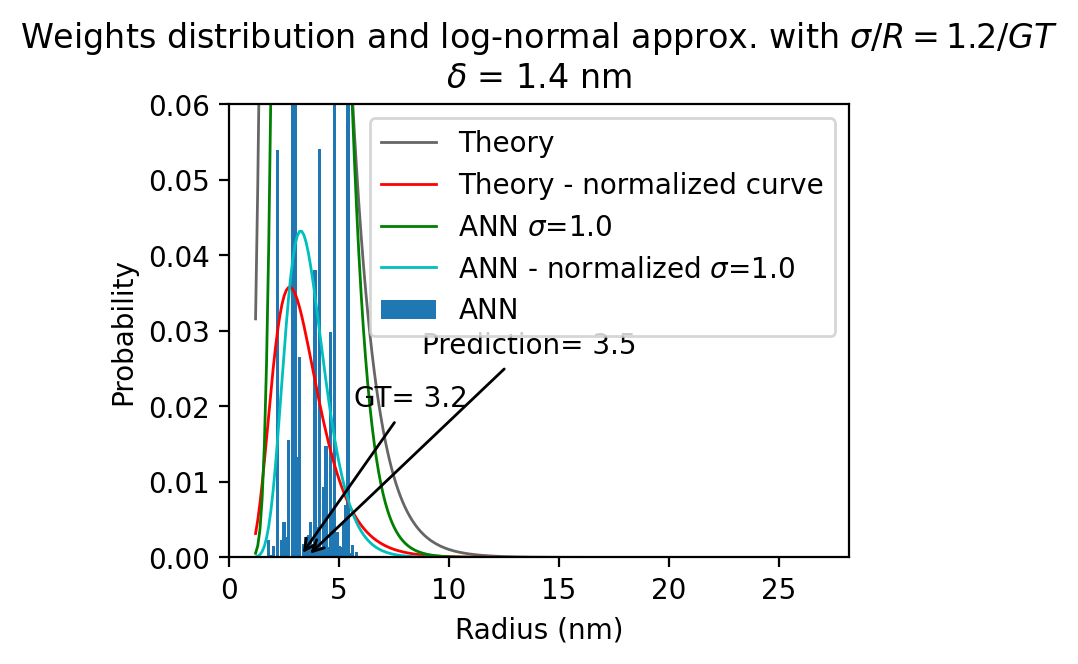

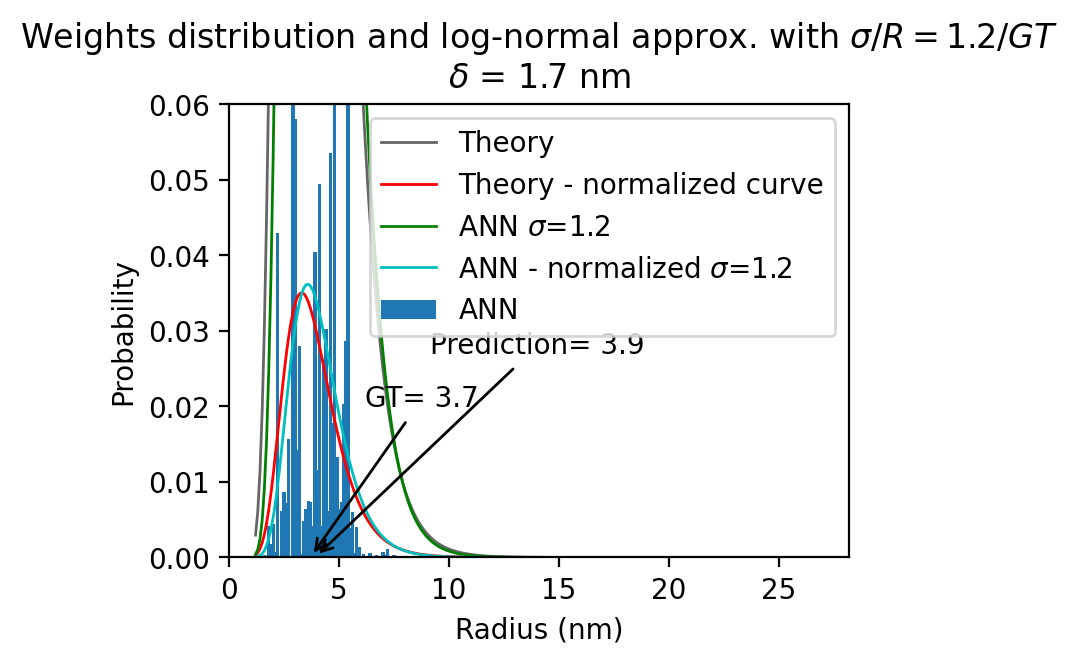

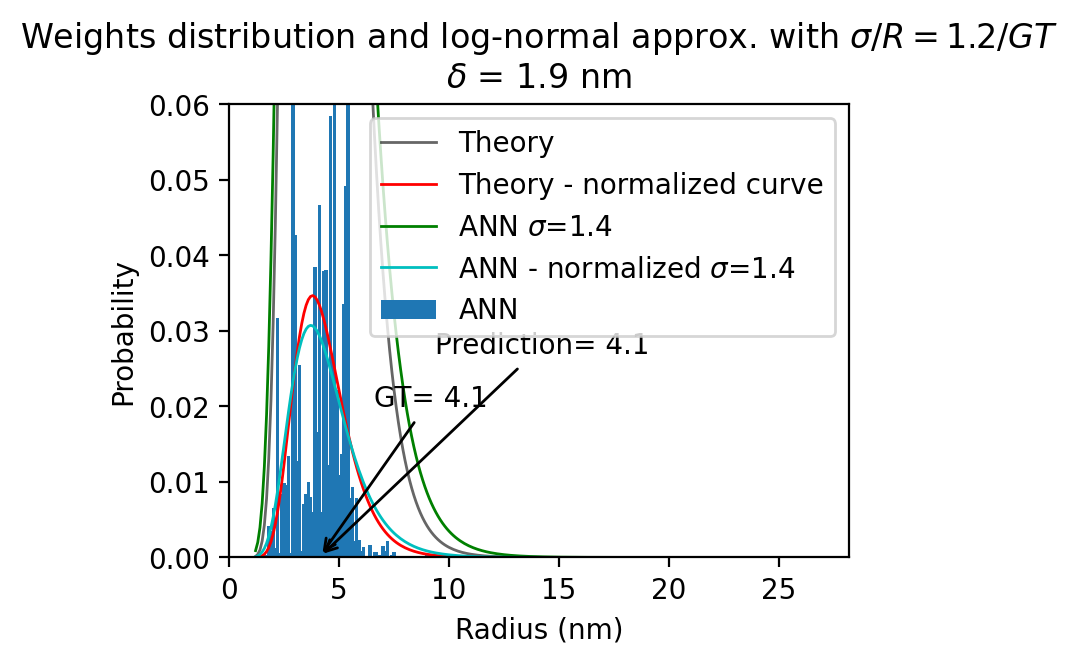

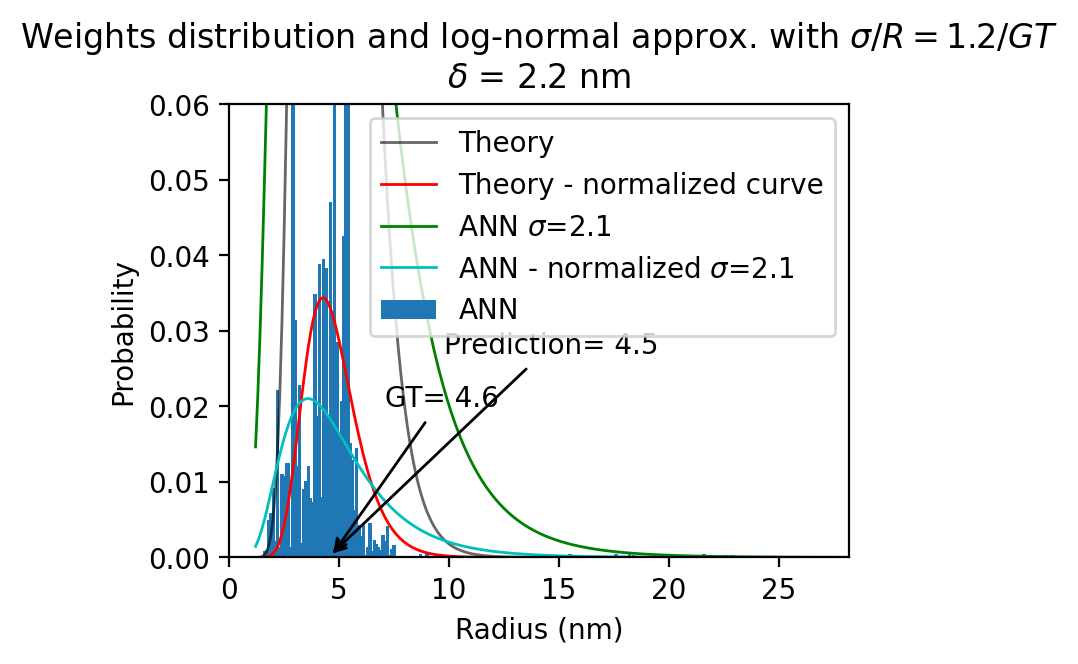

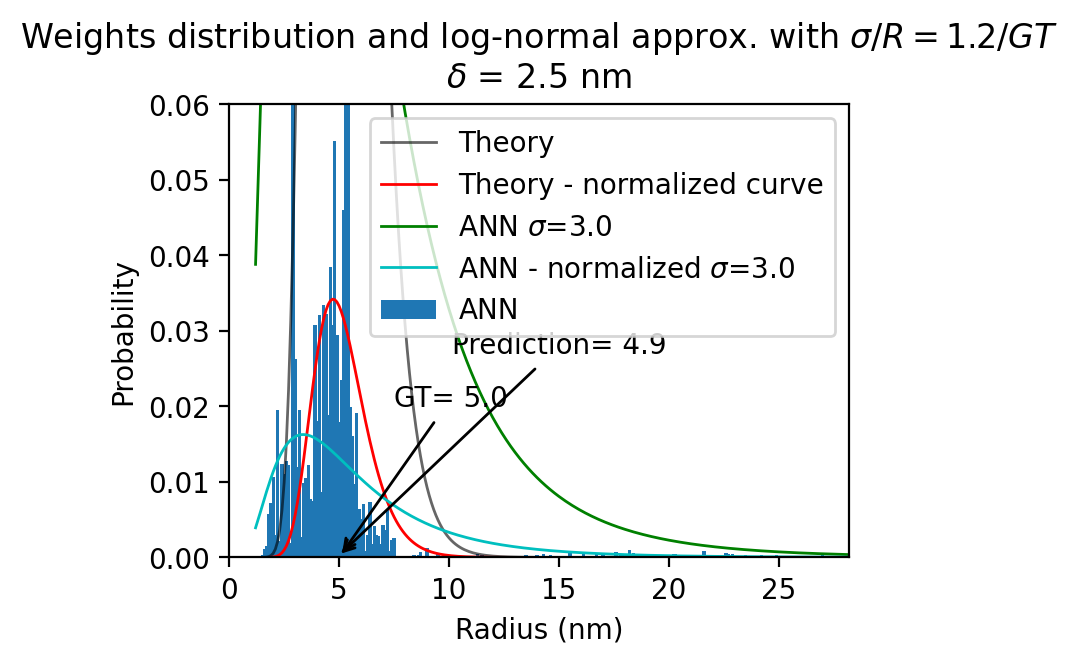

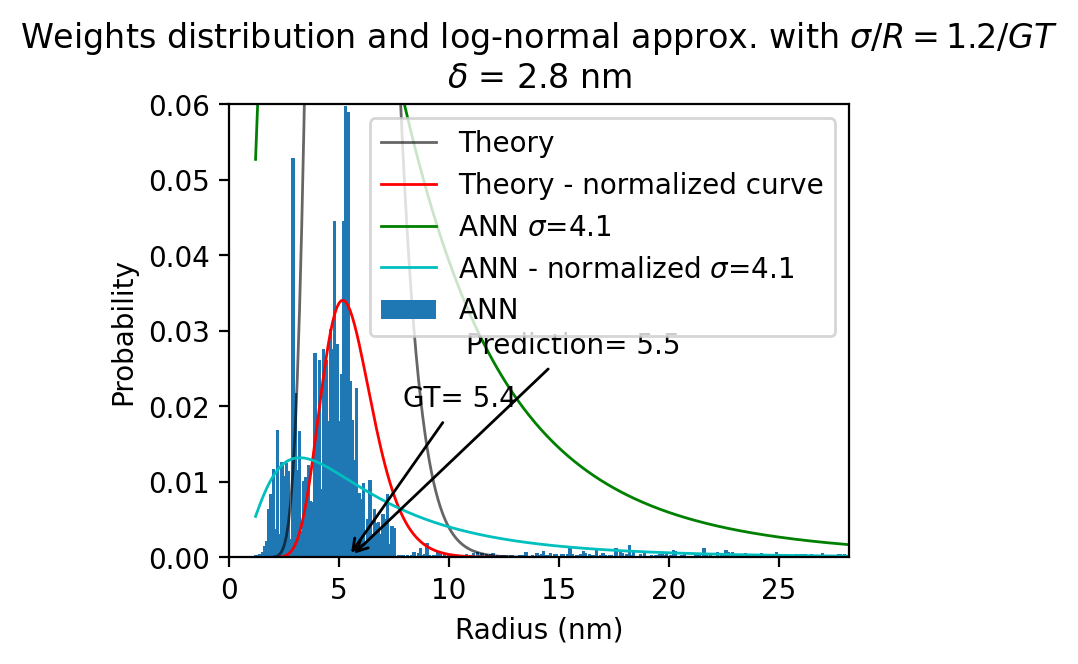

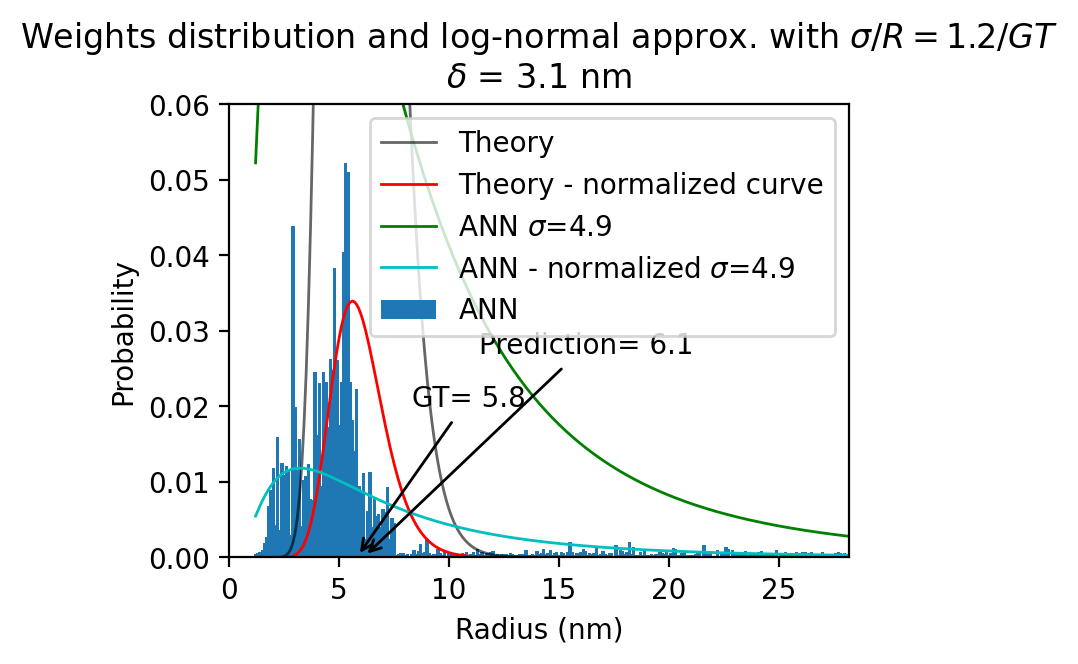

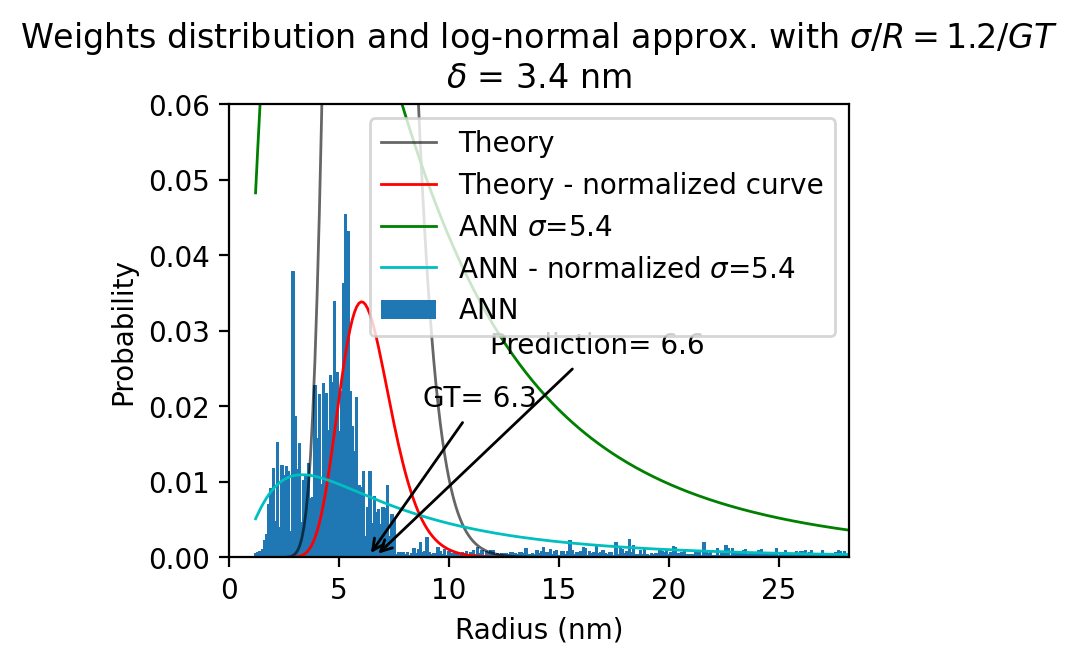

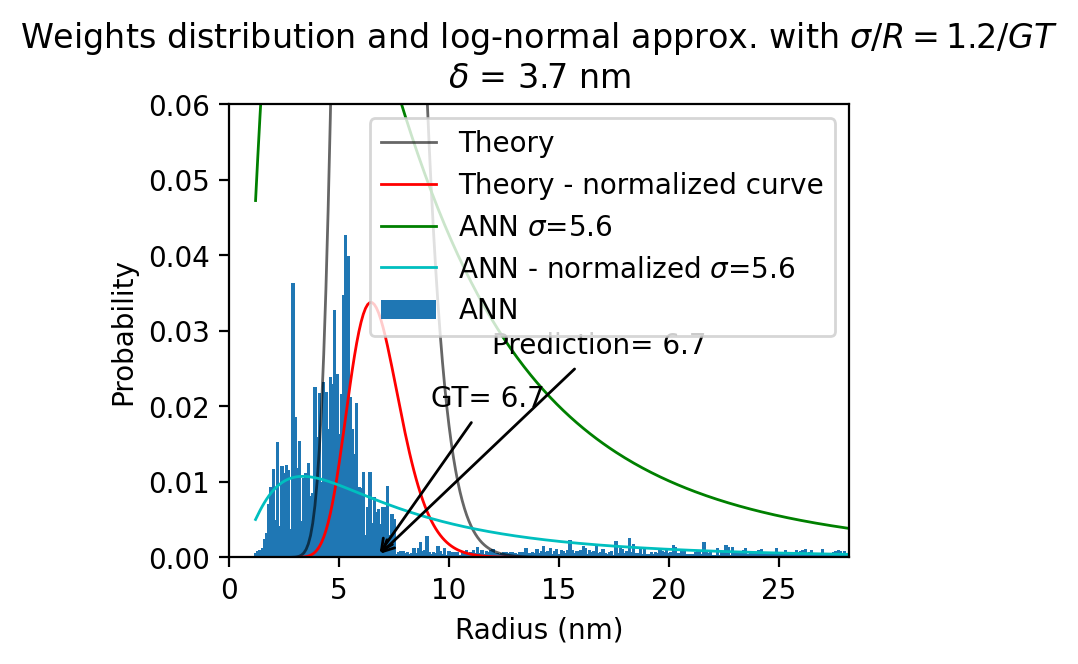

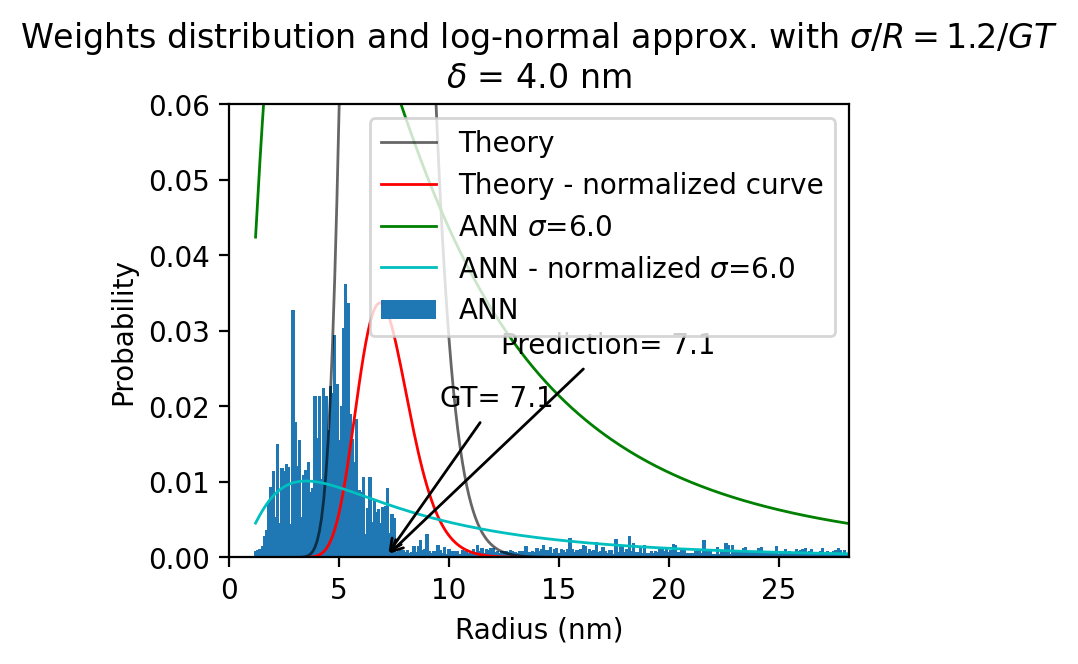

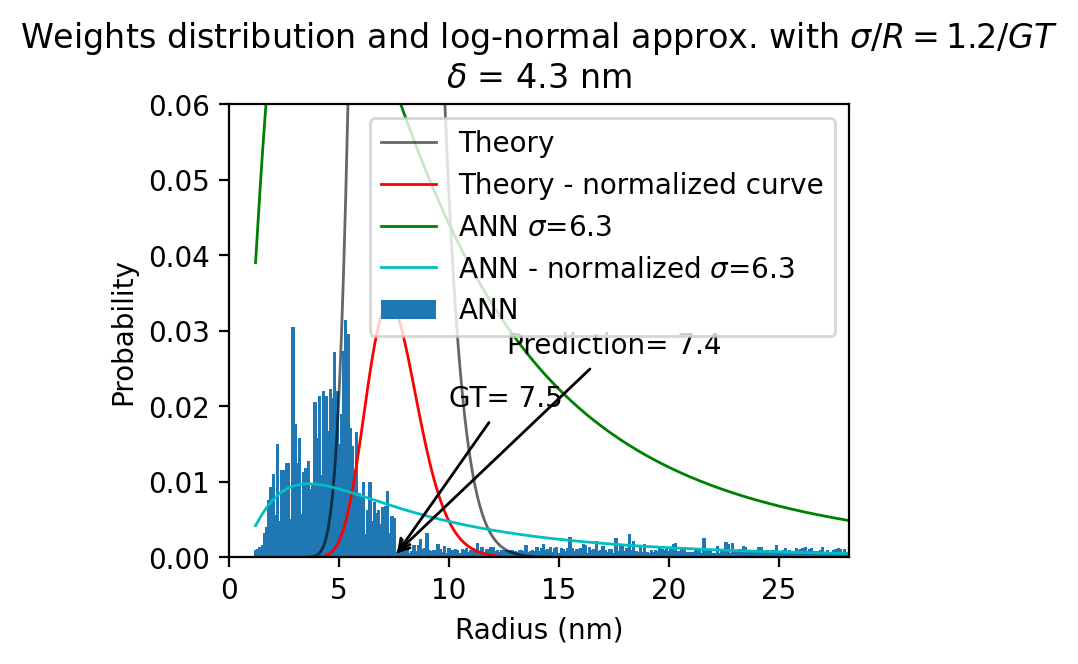

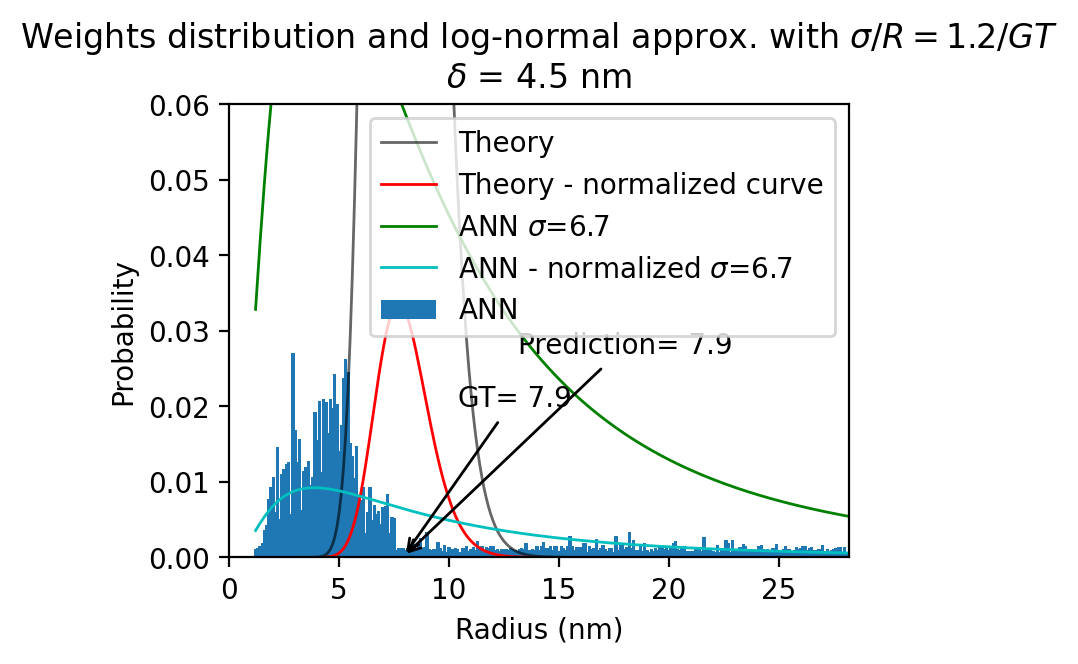

In [4]:
b75_mlplr_radius_100K = 'examples/pred_exp_100K_radius_raw_mlplr_75b.npy'  # raw output of the NN for experiment data set T = 100k
b75_mlplr_radius_500K = 'examples/pred_exp_500K_radius_raw_mlplr_75b.npy'  # raw output of the NN for experiment data set T = 500k
raw_data = get_raw_data(b75_mlplr_radius_500K)
distance,radius = get_experiment_data('500') # Those are the groud truth values I have fro the distance and radius 
plot_bars(frames=range(0,120,10),label=False,save=False,flag='radius',k='500')